<a href="https://colab.research.google.com/github/DrMiracle/Colab-Projects/blob/main/YOLO_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets torchvision
!pip install -U yolov5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

from functools import partial

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.models import alexnet
from torchvision.models.detection import fasterrcnn_resnet50_fpn

from datasets import load_dataset

import matplotlib.pyplot as plt

import cv2

_CATEGORIES = ['player', 'football']

%matplotlib inline

In [ ]:
ds = load_dataset("keremberke/football-object-detection")
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

football-object-detection.py:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/76.2M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/21.3M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/859 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/243 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/130 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 859
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 243
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 130
    })
})

Train examples: 859
Image sizes: {(1280, 720)}
Mean area: 2945.40507518797
Max area: 418413
Min area: 13


(0.0, 10000.0)

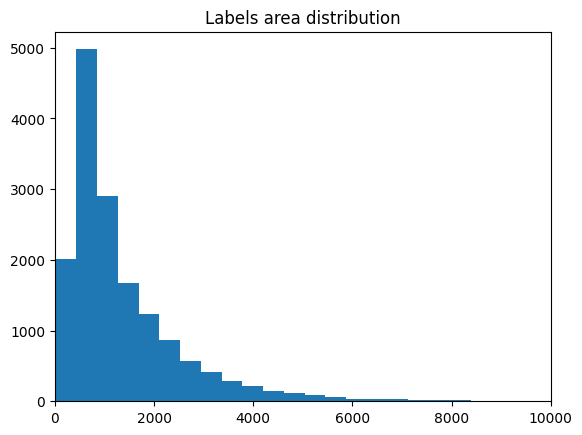

In [ ]:
print(f"Train examples: {len(ds['train'])}")

img_sizes = set()
for img in ds['train']['image']:
  if img.size not in img_sizes:
    img_sizes.add(img.size)
print(f"Image sizes: {img_sizes}")

areas = []
for objects in ds['train']['objects']:
  for area in objects['area']:
    areas.append(area)
print(f"Mean area: {np.mean(areas)}")
print(f"Max area: {np.max(areas)}")
print(f"Min area: {np.min(areas)}")

plt.hist(areas, bins = 1000)
plt.title("Labels area distribution")
plt.xlim(0, 10000)

Validation examples: 243
Image sizes: {(1280, 720)}
Mean area: 2952.6452470640374
Max area: 311845
Min area: 14


(0.0, 10000.0)

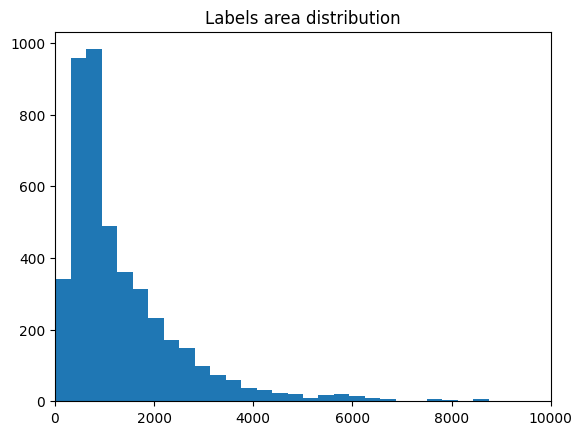

In [ ]:
print(f"Validation examples: {len(ds['validation'])}")

img_sizes = set()
for img in ds['validation']['image']:
  if img.size not in img_sizes:
    img_sizes.add(img.size)
print(f"Image sizes: {img_sizes}")

areas = []
for objects in ds['validation']['objects']:
  for area in objects['area']:
    areas.append(area)
print(f"Mean area: {np.mean(areas)}")
print(f"Max area: {np.max(areas)}")
print(f"Min area: {np.min(areas)}")

plt.hist(areas, bins = 1000)
plt.title("Labels area distribution")
plt.xlim(0, 10000)

Test examples: 130
Image sizes: {(1280, 720)}
Mean area: 2472.355509355509
Max area: 277395
Min area: 17


(0.0, 10000.0)

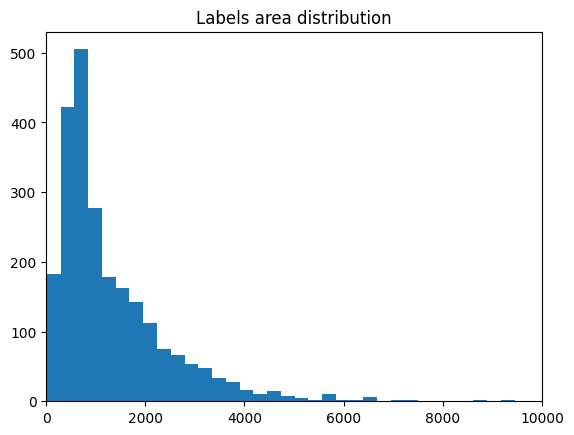

In [ ]:
print(f"Test examples: {len(ds['test'])}")

img_sizes = set()
for img in ds['test']['image']:
  if img.size not in img_sizes:
    img_sizes.add(img.size)
print(f"Image sizes: {img_sizes}")

areas = []
for objects in ds['test']['objects']:
  for area in objects['area']:
    areas.append(area)
print(f"Mean area: {np.mean(areas)}")
print(f"Max area: {np.max(areas)}")
print(f"Min area: {np.min(areas)}")

plt.hist(areas, bins = 1000)
plt.title("Labels area distribution")
plt.xlim(0, 10000)

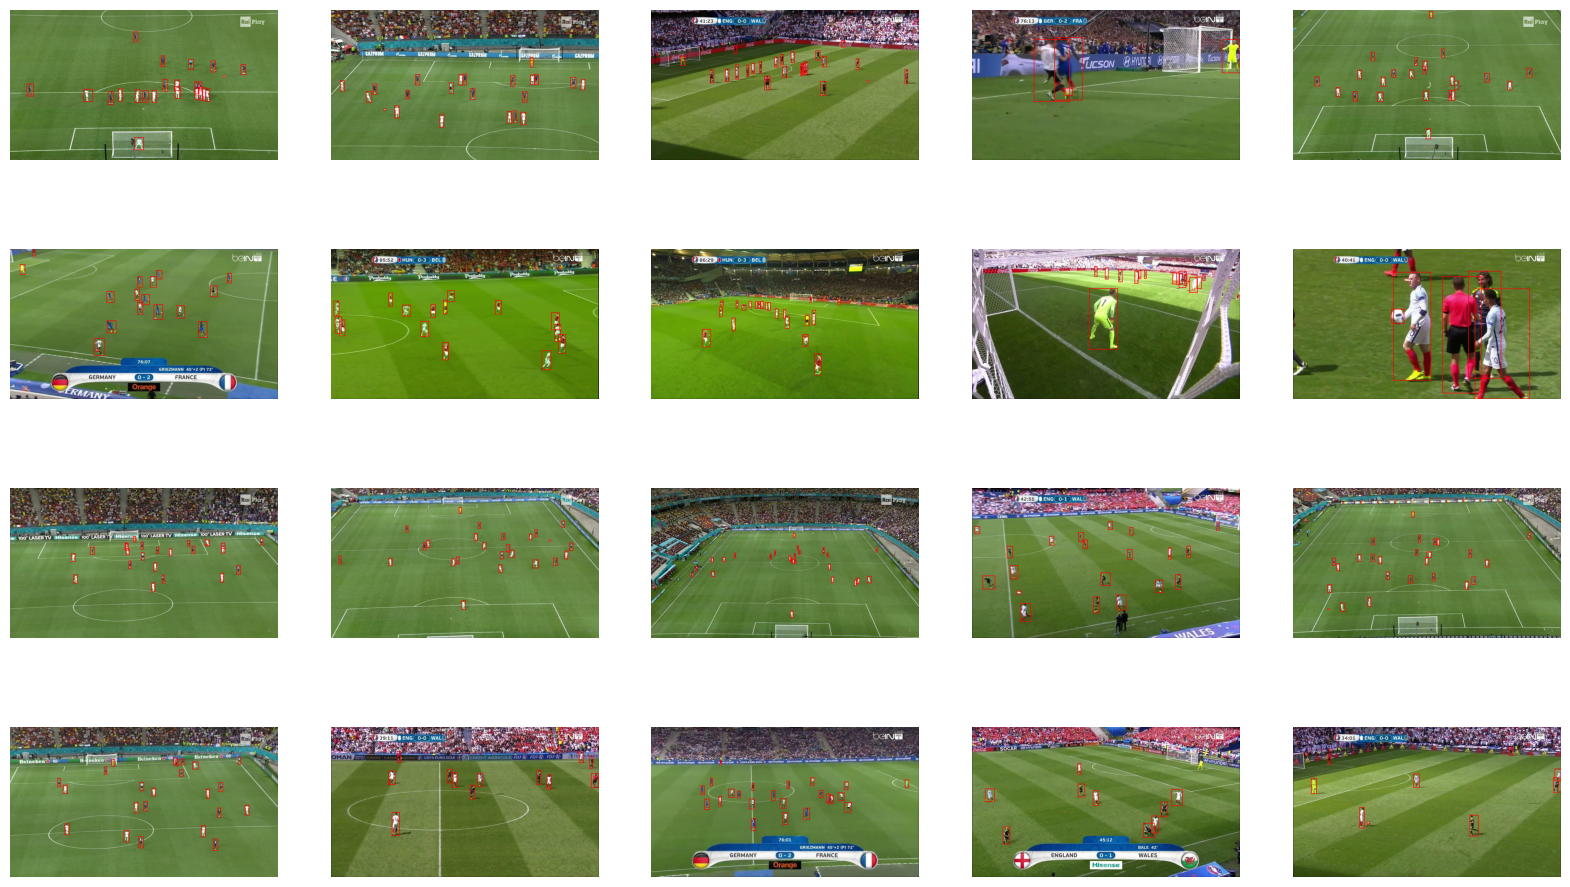

In [ ]:
def display_images_in_grid(images, cols, figsize=(20, 15)):
    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / cols + 1), cols, i + 1)
        plt.imshow(image)
        plt.axis('off')

imgs = []
for i in range(20):
  img = ds['train']['image'][i]
  draw = ImageDraw.Draw(img)
  for bbox in ds['train']['objects'][i]['bbox']:
    draw.rectangle((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]), outline = "red", width = 3)
  imgs.append(img)

display_images_in_grid(imgs, 5)

Під час препроцесінгу зображень, вони були перетворенні в тензори та нормалізовані. Так само і баундінг бокси були нормалізовані, а класи переведені в one-hot вектор та додані до вектору баундінг боксу. Нормалізація зображень пришвидшує тренування, запобігає вибухаючому або зникаючому градієнту та усуває зсув у вхідних даних.

In [ ]:
import os
import json
from PIL import Image
from shutil import copy2
from tqdm import tqdm

output_dir = 'yolo_dataset'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def create_yolo_format_bbox(image_id, objects, img_width, img_height, output_path):
    """Create YOLO format .txt file with bounding boxes for a given image."""
    with open(output_path, 'w') as f:
        for i, obj in enumerate(objects['bbox']):
            class_id = objects['category'][i]
            x_min, y_min, bbox_width, bbox_height = obj

            # Convert bbox to YOLO format (normalized x_center, y_center, width, height)
            x_center = (x_min + bbox_width / 2) / img_width
            y_center = (y_min + bbox_height / 2) / img_height
            norm_width = bbox_width / img_width
            norm_height = bbox_height / img_height

            f.write(f"{class_id} {x_center} {y_center} {norm_width} {norm_height}\n")

def process_dataset(split, dataset, output_split_dir):
    """Process each dataset split (train, validation, test)"""
    for idx in tqdm(range(len(dataset)), desc=f"Processing {split}"):
        data = dataset[idx]
        image = data['image']
        image_id = data['image_id']
        img_width = int(data['width'])
        img_height = int(data['height'])
        objects = data['objects']

        img_output_path = os.path.join(output_split_dir, f"{image_id}.jpg")
        label_output_path = os.path.join(output_split_dir, f"{image_id}.txt")

        image.save(img_output_path)

        create_yolo_format_bbox(image_id, objects, img_width, img_height, label_output_path)

process_dataset('train', ds['train'], train_dir)
process_dataset('validation', ds['validation'], val_dir)
process_dataset('test', ds['test'], test_dir)


Processing test: 100%|██████████| 130/130 [00:01<00:00, 103.24it/s]


In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 17026, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 17026 (delta 1), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17026/17026), 15.63 MiB | 25.12 MiB/s, done.
Resolving deltas: 100% (11691/11691), done.
/content/yolov5
Setup complete. Using torch 2.5.0+cu121 (CPU)


In [ ]:
!wandb login 40b6e1b7dcc7b003b03bc4b4bea56d506378ebb3

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

run = wandb.init(project="yolo-laboratory")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yevgenstefaniuk (yevgenstefaniuk-national-university-of-kyiv-mohyla-academy-). Use `wandb login --relogin` to force relogin


In [ ]:
import wandb

sweep_config = {
    'method': 'bayes',
    'name': 'yolo-sweep',
    'metric': {
        'goal': 'minimize',  # minimize loss
        'name': 'total_loss'
    },
    'parameters': {
        'batch_size': {
            'values': [16, 32, 64]
        },
        'optimizer': {
            'values': ['Adam', 'SGD']
        },
        'lr0': {
            'min': 0.001,
            'max': 0.01
        },
        'lrf': {
            'min': 0.01,
            'max': 0.1
        },
        'momentum': {
            'min': 0.85,
            'max': 0.95
        },
        'weight_decay': {
            'min': 0.0001,
            'max': 0.001
        }
    }
}


sweep_configuration = wandb.sweep(sweep_config, project="yolo-laboratory")

Create sweep with ID: uhe103le
Sweep URL: https://wandb.ai/yevgenstefaniuk-national-university-of-kyiv-mohyla-academy-/yolo-laboratory/sweeps/uhe103le


In [ ]:
import wandb
import yaml

def train_with_sweep(config=None):
    with wandb.init(config=config):
        batch_size = wandb.config.batch_size
        optimizer = wandb.config.optimizer
        lr0 = wandb.config.lr0
        lrf = wandb.config.lrf
        momentum = wandb.config.momentum
        weight_decay = wandb.config.weight_decay

        hyperparams = {
            'lr0': lr0,
            'lrf': lrf,
            'momentum': momentum,
            'weight_decay': weight_decay,
            # Standart YOLO hyperparameters
            'warmup_epochs': 3.0, # warmup epochs (fractions ok)
            'warmup_momentum': 0.8, # warmup initial momentum
            'warmup_bias_lr': 0.1, # warmup initial bias lr
            'box': 0.05, # box loss gain
            'cls': 0.5, # cls loss gain
            'cls_pw': 1.0, # cls BCELoss positive_weight
            'obj': 1.0, # obj loss gain (scale with pixels)
            'obj_pw': 1.0, # obj BCELoss positive_weight
            'iou_t': 0.20, # IoU training threshold
            'anchor_t': 4.0, # anchor-multiple threshold
            # 'anchors': 3,  # anchors per output layer (0 to ignore)
            'fl_gamma': 0.0, # focal loss gamma (efficientDet default gamma=1.5)
            'hsv_h': 0.015, # image HSV-Hue augmentation (fraction)
            'hsv_s': 0.7, # image HSV-Saturation augmentation (fraction)
            'hsv_v': 0.4, # image HSV-Value augmentation (fraction)
            'degrees': 0.0, # image rotation (+/- deg)
            'translate': 0.1, # image translation (+/- fraction)
            'scale': 0.5, # image scale (+/- gain)
            'shear': 0.0, # image shear (+/- deg)
            'perspective': 0.0, # image perspective (+/- fraction), range 0-0.001
            'flipud': 0.0, # image flip up-down (probability)
            'fliplr': 0.5, # image flip left-right (probability)
            'mosaic': 1.0, # image mosaic (probability)
            'mixup': 0.0, # image mixup (probability)
            'copy_paste': 0.0, # segment copy-paste (probability)
        }

        with open("sweep_hyperparams.yaml", "w") as f:
            yaml.dump(hyperparams, f)

        !python train.py --img 640 \
                         --batch $batch_size \
                         --epochs 5 \
                         --hyp sweep_hyperparams.yaml \
                         --data /content/data.yaml \
                         --weights yolov5s.pt \
                         --project "yolo-laboratory" \
                         --name "fine tuning" \
                         --entity "yevgenstefaniuk" \
                         --optimizer $optimizer

        run = wandb.Api().run(f"yevgenstefaniuk-national-university-of-kyiv-mohyla-academy-/yolo-laboratory/{wandb.run.id}")

        def get_latest_metric(metric_name):
          history = run.history(keys=[metric_name])
          if not history.empty:
              return history[metric_name].dropna().iloc[-1]
          else:
              return None

        val_box_loss = get_latest_metric("val/box_loss")
        print("Validation Box Loss:", val_box_loss)

        val_cls_loss = get_latest_metric("val/cls_loss")
        print("Validation Class Loss:", val_cls_loss)

        val_obj_loss = get_latest_metric("val/obj_loss")
        print("Validation Object Loss:", val_obj_loss)

        if val_box_loss and val_cls_loss and val_obj_loss:
            total_loss = val_box_loss + val_cls_loss + val_obj_loss
            wandb.log({'total_loss': total_loss})
            print("Loss logged.")

In [ ]:
# Start the sweep
wandb.agent(sweep_configuration, function=train_with_sweep, count=3)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7b57d849b670>> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: qr6nta3b with config:
wandb: 	batch_size: 16
wandb: 	lr0: 0.0019109327470628208
wandb: 	lrf: 0.08645515325287452
wandb: 	momentum: 0.8607167231332881
wandb: 	optimizer: Adam
wandb: 	weight_decay: 0.000784095341499634
wandb: ERROR Problem finishing run


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-07 19:53:05.915115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 19:53:05.934559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 19:53:05.940873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: yevgenstefaniuk (yevgenstefaniuk-national-university-of-kyiv-mohyla-academy-). Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=/content/da

wandb: Agent Starting Run: dcukcf8c with config:
wandb: 	batch_size: 32
wandb: 	lr0: 0.006249740540746615
wandb: 	lrf: 0.04887445720657496
wandb: 	momentum: 0.9092601167484732
wandb: 	optimizer: SGD
wandb: 	weight_decay: 0.00025581414533271975


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-07 19:53:31.460014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 19:53:31.479396: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 19:53:31.485315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: yevgenstefaniuk (yevgenstefaniuk-national-university-of-kyiv-mohyla-academy-). Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=/content/da

In [ ]:
!python train.py --img 640 --epochs 5 --data /content/data.yaml --weights yolov5s.pt \
    --project "lab-yolo" --name "hyperparams run" --entity "yevgenstefaniuk" --optimizer Adam \
    --batch ${batch_size} --lr ${lr}


In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/data.yaml --weights yolov5s.pt

Показано результат, скорочений до останніх рядків (5000).
  with torch.cuda.amp.autocast(amp):
       6/49      3.58G    0.05868     0.0632   0.003072        589        640:  30% 16/54 [00:09<00:24,  1.55it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       6/49      3.58G    0.05862     0.0637   0.003049        549        640:  31% 17/54 [00:11<00:35,  1.05it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       6/49      3.58G    0.05856    0.06368   0.003012        607        640:  33% 18/54 [00:11<00:26,  1.34it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast